# Exp 38

### Compare models on 28 classes

31 classes that have 200 or more files, minus 'text' and 'unk' that are not filetypes.

In [6]:
import os
import datetime
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

import models
import report
import block_sampler
import batch_encoder
from dataset import Dataset
from report import Reporter
from trainer import Trainer
from attention import Attention, showSample
from batch_encoder import Dataset
from block_sampler import count_sectors, BlockSamplerByCategory, RandomSampler
from batch_encoder import xs_encoder_8bits_11, BatchEncoder
from filter_random import gen_rndchk_models, evaluate_rnd_model, filter_dataset

from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, TimeDistributed, Flatten, Dot, Softmax, Lambda
import tensorflow.keras.backend as K

In [2]:
tensorflow.__version__, tensorflow.keras.__version__

('1.14.0', '2.2.4-tf')

In [3]:
tensorflow.test.is_gpu_available(), tensorflow.test.is_built_with_cuda()

(False, False)

In [4]:
# raw_dataset_folder='/home/user/sample200'
raw_dataset_folder='../datasets/govdocs1/sample200'
random_dataset_folder='../datasets/random'
minimum=200
maximum=200
result_dir = 'results/exp38'
os.makedirs(result_dir, exist_ok=True)

In [5]:
rawset = Dataset.new_from_folders(raw_dataset_folder).filter_min_max(minimum, maximum)
rawset = rawset.filter(lambda x: rawset.category_from(x) not in ['text', 'unk'])
rawset.rebuild_categories()

# Train model

In [5]:
model = models.C64_16_2pr_C32_4_2pr_C64_32_2pr_F_D(
        28, 8, 'softmax', 'categorical_crossentropy')

In [6]:
result = Trainer(model).train(*rawset.rnd_split_fraction_by_category(0.5))

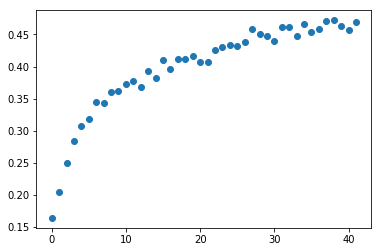

In [7]:
plt.plot(result.history.history['val_categorical_accuracy'], 'o')

In [21]:
result.model.save(result_dir + '/28classes.h5')

In [ ]:
r = report.Reporter2(result_dir + '/28classes.tsv')

r.line(name=result.model.name,
       elapsed=result.elapsed,
       **report.report_epochs(**result._asdict()),
       **report.report_metrics(result.history, result.metrics),
      )

r.close()

In [44]:
pd.read_csv(result_dir + '/28classes.tsv', sep='\t')

,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
0,C64_16_2pr_C32_4_2pr_C64_32_2pr_F_D28_cat,256.885371,42,0.972862,0.468625


# CLD

In [37]:
model = models.C256_16_16_L128_D(28, 8, 'softmax', 'categorical_crossentropy')

In [38]:
result = Trainer(model).train(*rawset.rnd_split_fraction_by_category(0.5))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


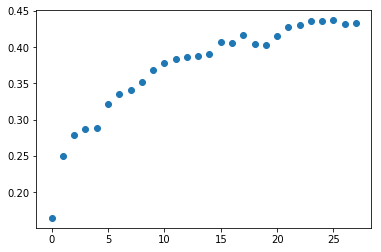

In [39]:
plt.plot(result.history.history['val_categorical_accuracy'], 'o')

In [40]:
result.model.save(result_dir + '/28classes-CLD.h5')

In [41]:
r = report.Reporter2(result_dir + '/28classes-CLD.tsv')

r.line(name=result.model.name,
       elapsed=result.elapsed,
       **report.report_epochs(**result._asdict()),
       **report.report_metrics(result.history, result.metrics),
      )

r.close()

In [42]:
pd.read_csv(result_dir + '/28classes-CLD.tsv', sep='\t')

,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
0,C256_16_16_L128_D28_cat,205.507304,28,0.971437,0.433875


# Attention

In [7]:
def mkmodel(classes, len_byte_vector, activation='softmax', loss='categorical_crossentropy'):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(64, (16,), strides=1, padding='same', activation='relu')(last)
    last = Conv1D(32, (4,), strides=1, padding='same', activation='relu')(last)
    last = Attention(512, 32, name='attScores')(last)
    last = Dense(classes)(last)
    last = Activation(activation)(last)
    model = tensorflow.keras.Model(l0, last, name='attentionModel')
    model.compile(loss=loss,
        optimizer=tensorflow.keras.optimizers.Adam(),
        metrics=['categorical_accuracy', 'binary_accuracy'])
    return model

In [8]:
model = mkmodel(28, 8)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
model.summary()

Model: "attentionModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 8)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 512, 64)      8256        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 512, 32)      8224        conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 1, 32)        0           conv1d_1[0][0]                   
_____________________________________________________________________________________

In [14]:
result = Trainer(model).train(*rawset.rnd_split_fraction_by_category(0.5))

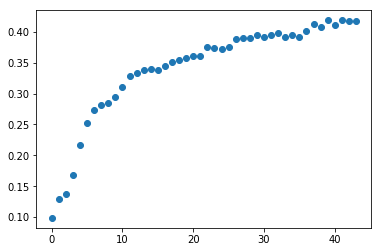

In [15]:
plt.plot(result.history.history['val_categorical_accuracy'], 'o')

In [16]:
result.model.save(result_dir + '/28classes-attention.h5')

In [11]:
r = report.Reporter2(result_dir + '/28classes-attention.tsv')

r.line(name=result.model.name,
       elapsed=result.elapsed,
       **report.report_epochs(**result._asdict()),
       **report.report_metrics(result.history, result.metrics),
      )

r.close()

NameError: name 'result' is not defined

# Load attention model

In [7]:
model = tensorflow.keras.models.load_model(result_dir + '/28classes-attention.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
layer_name = 'attScores'
attention_layer_model = tensorflow.keras.Model(inputs=model.input,
                                               outputs=model.get_layer(layer_name).output)

In [10]:
pd.read_csv(result_dir + '/28classes-attention.tsv', sep='\t')

,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
0,attentionModel,615.2426114082336,35,0.9702635,0.39675
1,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
2,attentionModel,280.6747500896454,44,0.97173667,0.4175


# Show attention

#### Select the 'pdf' category

In [11]:
by_category = rawset.by_category()
batch_size = 100
cat = 'pdf'
cat_n = rawset.cat_to_ix[cat]
mycat = by_category[cat]
mycat.rebuild_categories(rawset.categories)
sampler = block_sampler.BlockSamplerByFile(by_category[cat])
encoder = batch_encoder.BatchEncoder(sampler, batch_size=batch_size,xs_encoder='8bits_11')
itencoder = iter(encoder)

Pick a sample batch

In [12]:
sample = next(itencoder)
attention_output = attention_layer_model.predict(sample)
prediction = model.predict(sample)

(array([ 5., 11., 13., 41., 14.,  5.,  4.,  2.,  1.,  4.]),
 array([0.0031542 , 0.02445825, 0.0457623 , 0.06706635, 0.0883704 ,
        0.10967445, 0.1309785 , 0.15228254, 0.17358659, 0.19489063,
        0.21619469], dtype=float32),
 <a list of 10 Patch objects>)

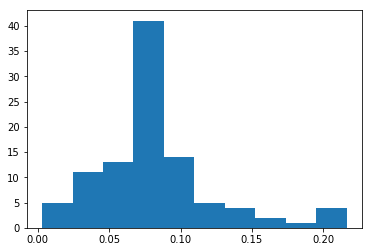

In [14]:
plt.hist(prediction[:,cat_n])

In [15]:
s0 = sample[0][prediction[:, cat_n]>0.17]
s1 = sample[1][prediction[:, cat_n]>0.17]
sample = (s0,s1)
attention_output = attention_layer_model.predict(sample)
prediction = model.predict(sample)

(array([1., 0., 0., 0., 0., 0., 1., 0., 0., 3.]),
 array([0.17902128, 0.18273863, 0.18645597, 0.1901733 , 0.19389065,
        0.197608  , 0.20132533, 0.20504266, 0.20876001, 0.21247736,
        0.21619469], dtype=float32),
 <a list of 10 Patch objects>)

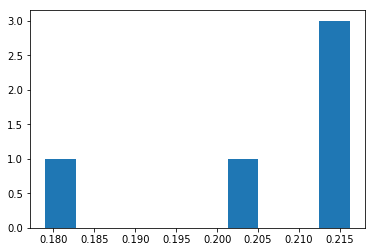

In [16]:
plt.hist(prediction[:,cat_n])

Show some instance

20
ps


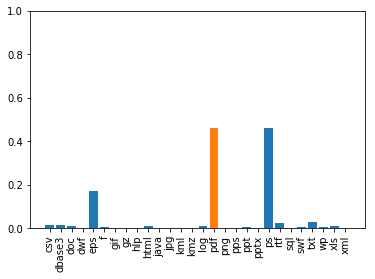

In [18]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 0)

20
ps


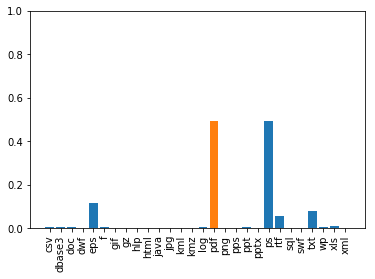

In [19]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 1)

20
ps


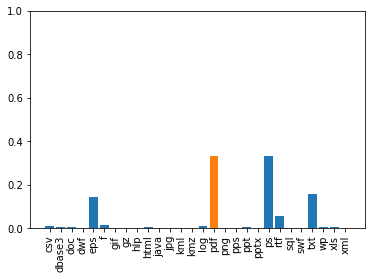

In [20]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 2)

20
ps


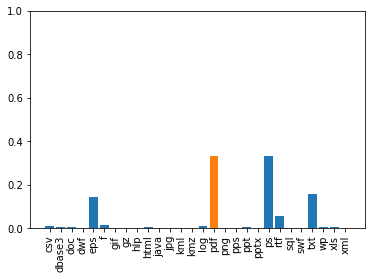

In [21]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 3)

#### Select the 'doc' category

In [22]:
by_category = rawset.by_category()
batch_size = 100
cat = 'doc'
cat_n = rawset.cat_to_ix[cat]
mycat = by_category[cat]
mycat.rebuild_categories(rawset.categories)
sampler = block_sampler.BlockSamplerByFile(by_category[cat])
encoder = batch_encoder.BatchEncoder(sampler, batch_size=batch_size,xs_encoder='8bits_11')
itencoder = iter(encoder)

Pick a sample batch

In [23]:
sample = next(itencoder)
attention_output = attention_layer_model.predict(sample)
prediction = model.predict(sample)

In [24]:
prediction.shape, sample[0].shape, sample[1].shape

((100, 28), (100, 512, 8), (100, 28))

(array([39.,  7.,  6.,  3.,  3.,  4., 25.,  8.,  4.,  1.]),
 array([0.00526478, 0.08621363, 0.16716248, 0.24811132, 0.32906017,
        0.410009  , 0.49095786, 0.5719067 , 0.6528555 , 0.7338044 ,
        0.81475323], dtype=float32),
 <a list of 10 Patch objects>)

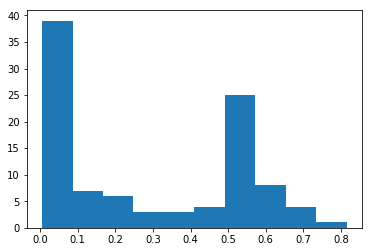

In [25]:
plt.hist(prediction[:,cat_n])

In [26]:
s0 = sample[0][prediction[:, cat_n]>0.6]
s1 = sample[1][prediction[:, cat_n]>0.6]
sample = (s0,s1)
attention_output = attention_layer_model.predict(sample)
prediction = model.predict(sample)

(array([5., 2., 3., 0., 1., 0., 0., 0., 0., 1.]),
 array([0.6235181 , 0.6426416 , 0.66176516, 0.68088865, 0.70001215,
        0.71913564, 0.7382592 , 0.7573827 , 0.7765062 , 0.79562974,
        0.81475323], dtype=float32),
 <a list of 10 Patch objects>)

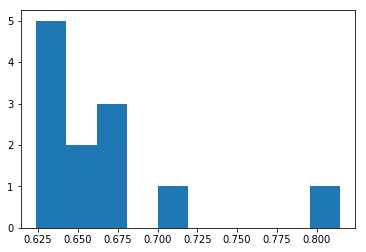

In [27]:
plt.hist(prediction[:,cat_n])

Show some instance

2
doc


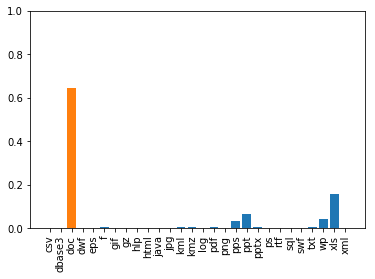

In [28]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 0)

2
doc


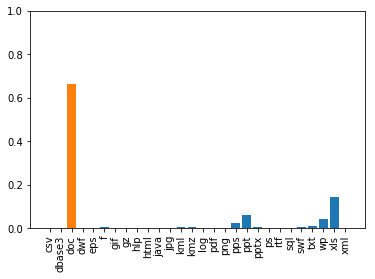

In [29]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 1)

2
doc


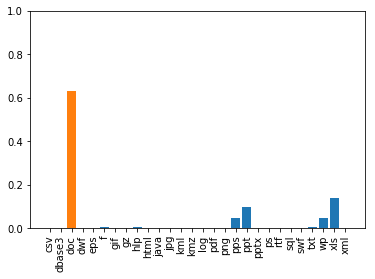

In [30]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 2)

2
doc


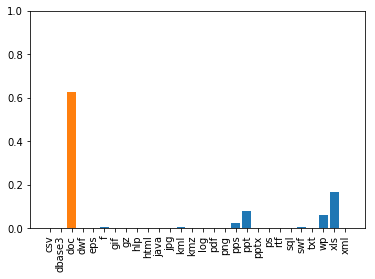

In [31]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 3)

#### Select the 'dbase3' category

In [32]:
by_category = rawset.by_category()
batch_size = 100
cat = 'dbase3'
cat_n = rawset.cat_to_ix[cat]
mycat = by_category[cat]
mycat.rebuild_categories(rawset.categories)
sampler = block_sampler.BlockSamplerByFile(by_category[cat])
encoder = batch_encoder.BatchEncoder(sampler, batch_size=batch_size,xs_encoder='8bits_11')
itencoder = iter(encoder)

Pick a sample batch

In [33]:
sample = next(itencoder)
attention_output = attention_layer_model.predict(sample)
prediction = model.predict(sample)

In [34]:
prediction.shape, sample[0].shape, sample[1].shape

((100, 28), (100, 512, 8), (100, 28))

(array([ 2.,  1.,  0.,  0.,  1.,  1.,  5.,  3., 22., 65.]),
 array([0.00118714, 0.09977492, 0.19836271, 0.2969505 , 0.39553827,
        0.49412605, 0.59271383, 0.6913016 , 0.7898894 , 0.88847715,
        0.98706496], dtype=float32),
 <a list of 10 Patch objects>)

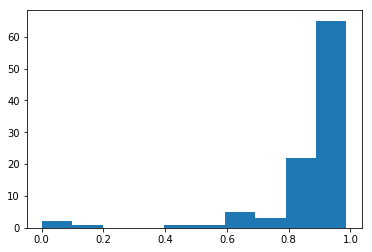

In [35]:
plt.hist(prediction[:,cat_n])

In [36]:
s0 = sample[0][prediction[:, cat_n]>0.8]
s1 = sample[1][prediction[:, cat_n]>0.8]
sample = (s0,s1)
attention_output = attention_layer_model.predict(sample)
prediction = model.predict(sample)

(array([ 1.,  3.,  3., 11.,  6.,  6.,  8., 14., 23., 11.]),
 array([0.81058705, 0.82823485, 0.84588265, 0.8635304 , 0.8811782 ,
        0.898826  , 0.9164738 , 0.9341216 , 0.95176935, 0.96941715,
        0.98706496], dtype=float32),
 <a list of 10 Patch objects>)

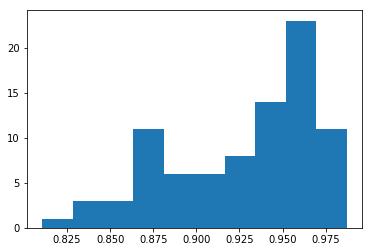

In [37]:
plt.hist(prediction[:,cat_n])

Show some instance

1
dbase3


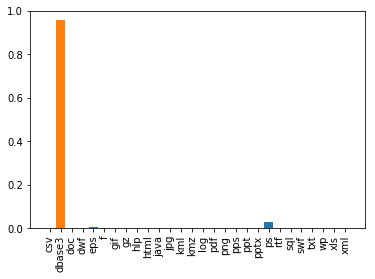

In [38]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 0)

1
dbase3


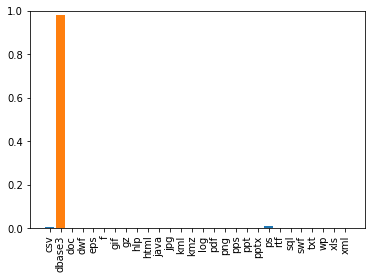

In [39]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 1)

1
dbase3


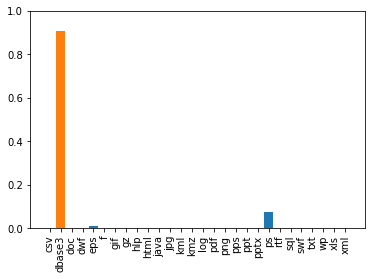

In [40]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 2)

1
dbase3


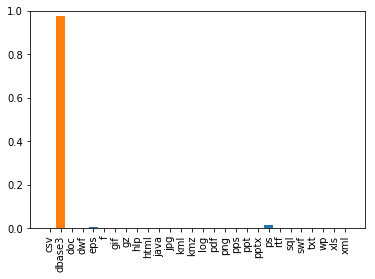

In [41]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 3)